In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
assert tf.__version__[0]=='2', 'please install tensorflow 2.x'

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import shap
import os

### Black-box 

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 17 11:19:52 2020

@author: evapa
"""
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, 
                                kernel_size=3, stride=1)
        self.batch1 = nn.BatchNorm2d(10, track_running_stats = False) 
        self.ReLU = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=50, 
                                kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=50, out_channels=80, 
                                kernel_size=3, stride=1)
        self.batch3 = nn.BatchNorm2d(80, track_running_stats = False)
        self.drop = nn.Dropout(0.6)
        self.fc1 = nn.Linear(in_features=29*29*80, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=2)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.ReLU(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.drop(x)
        x = self.batch3(x)
        x = self.ReLU(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
path = './use_cases/'

In [4]:
model = Net() # Initialize model
model.load_state_dict(torch.load(path+'Parametri_rete.pth',map_location=torch.device('cpu'))) # Load pretrained parameters
model.eval() # Set to eval mode to change behavior of Dropout, BatchNorm

Net(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (ReLU): ReLU()
  (conv2): Conv2d(10, 50, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(50, 80, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (drop): Dropout(p=0.6, inplace=False)
  (fc1): Linear(in_features=67280, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=2, bias=True)
)

## Images

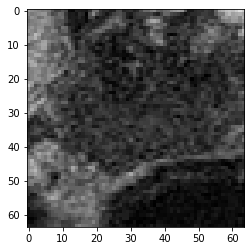

In [5]:
data_path = path+'data/Image_1.png'
img = Image.open(data_path)  # Load image as PIL.Image
img = img.convert('RGB')
plt.imshow(img)
plt.show()

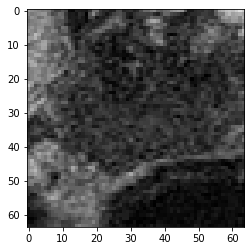

In [6]:
data_path = path+'data/Image_2.png'
img2 = Image.open(data_path)  # Load image as PIL.Image
img2 = img.convert('RGB')
plt.imshow(img2)
plt.show()

## LIME

  0%|          | 0/500 [00:00<?, ?it/s]

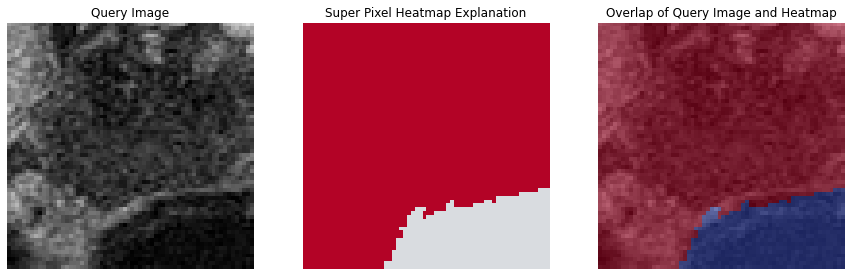

In [7]:
from xailib.explainers.lime_explainer import LimeXAIImageExplainer
from skimage.color import label2rgb


# 1) Create the Explainer
lm = LimeXAIImageExplainer(model)

# 2a) Fit the Explainer
lm.fit()

# 2b) Create custom classifier function if not predict 
# function that takes as input an array of images (the LIME neighbourhood) and return an array of (num_images,num_classes)
# If None will use black_box.predict function

def batch_predict(images):
    transform = transforms.ToTensor() #this already normalize RBG in range 0-1
    batch = torch.stack(tuple(transform(i) for i in images), dim=0)
    output = model(batch)  # Forward pass
    output = torch.nn.functional.softmax(output, dim=1)
    pred = torch.argmax(output,1)
    
    return pred.numpy().reshape(-1,1)

# 3) Explain an Instance
explanation = lm.explain(np.array(img), batch_predict, num_samples=500)

# 4) Plot the results
lm.plot_lime_values(np.array(img), explanation)

# IntGrad

In [8]:
def preprocessing(image):
    transform = transforms.ToTensor() #this already normalize RBG in range 0-1
    batch =  transform(image).unsqueeze(0).float()
    return batch

batch = preprocessing(np.array(img))

def predict(batch):
    n_classes = 2
    output = model(batch)  # Forward pass
    output = torch.nn.functional.softmax(output, dim=1)
    return output

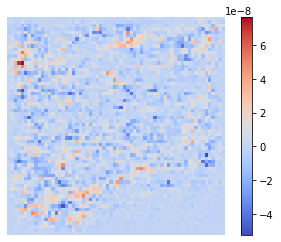

In [11]:
from xailib.explainers.intgrad_explainer import IntgradImageExplainer
from skimage.color import rgb2gray

# 1) Create the Explainer
ig = IntgradImageExplainer(model)

# 2) Fit the Explainer
ig.fit()

# 3) Select the image we want to give an explanation for
query = np.array(img)

# 4) Explain an Instance
scores = ig.explain(query, 1, 'black', preprocessing, predict, model_type='pytorch')

plt.imshow(rgb2gray(scores),cmap='coolwarm')
plt.colorbar()
plt.axis('off');

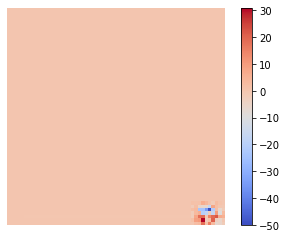

In [12]:
scores = ig.explain(query, 1, 'white', preprocessing, predict, model_type='pytorch')

plt.imshow(rgb2gray(scores),cmap='coolwarm')
plt.colorbar()
plt.axis('off');

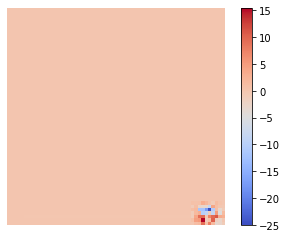

In [13]:
scores = ig.explain(query, 1, 'half', preprocessing, predict, model_type='pytorch')

plt.imshow(rgb2gray(scores),cmap='coolwarm')
plt.colorbar()
plt.axis('off');

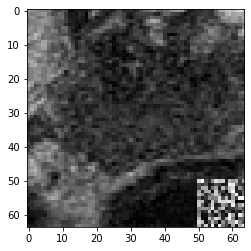

In [14]:
from skimage.color import gray2rgb
query = np.array(img)
query[50:,50:,:] = gray2rgb((np.random.rand(14,14)*255).astype(int))
plt.imshow(query);

In [15]:
predict(preprocessing(query))

tensor([[0.2577, 0.7423]], grad_fn=<SoftmaxBackward>)

# ILOREM

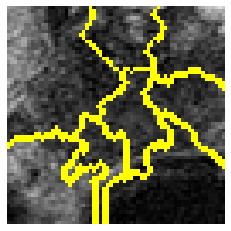

In [27]:
from skimage.segmentation import quickshift, mark_boundaries
from skimage.color import gray2rgb
image = gray2rgb(np.array(img).astype(int))
"""
First you need to define the segmentation function to use, in this example we will use
quickshift from skimage. It is foundamental to tune the parameters of the segmentation in
order to have a good one. It is recommentded to print an example of just only the segmentation
to see if it works for that kind of image
For quickshift we have to tune these two parameters below
kernel_size : float, optional
    Width of Gaussian kernel used in smoothing the
    sample density. Higher means fewer clusters.
max_dist : float, optional
    Cut-off point for data distances.
    Higher means fewer clusters.
"""
def segmentation_fn(image):
    return quickshift(image, kernel_size=3, max_dist=100)
plt.imshow(mark_boundaries(image/255,segmentation_fn(image)))
plt.axis('off');

In [32]:
from externals.LOREM.ilorem import ILOREM

# Function to convert from rgb2gray since the one implemented in skimage gives problems
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

#The predict function needs to take as input a list of RGB image 
#and return an array of class indices of shape (-1,1)

# Create the explainer

def batch_predict_LORE(images):
    transform = transforms.ToTensor() #this already normalize RBG in range 0-1
    batch = torch.stack(tuple(transform(i) for i in images), dim=0).float()
    output = model(batch)  # Forward pass
    output = torch.nn.functional.softmax(output, dim=1)
    pred = torch.argmax(output,1)
    
    return pred.numpy().reshape(-1,1)

explainer = ILOREM(bb_predict = batch_predict_LORE, 
                   neigh_type='lime',
                   class_name='class', 
                   class_values = [0,1], 
                   segmentation_fn=segmentation_fn,
                   verbose=True)

exp = explainer.explain_instance(np.array(img)/255, 
                                 num_samples=500, 
                                 use_weights=True, #pesa i punti in base alla distanza
                                 metric='euclidean',
                                 hide_color=255)

generating neighborhood - lime
synthetic neighborhood class counts {0: 305, 1: 245}
learning local decision tree
retrieving explanation


In [33]:
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp.rstr(), exp.cstr()))

e = {
	r = { 2 > 0.50, 1 > 0.50, 3 > 0.50 } --> { class: 1 }
	c = { { 2 <= 0.50 } --> { class: 0 }, { 1 <= 0.50 } --> { class: 0 } }    
}


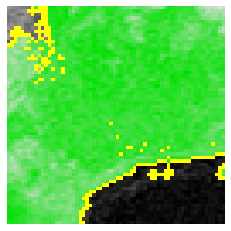

In [34]:
img2show, mask = exp.get_image_rule(hide_rest=False, 
                                    num_features=None, 
                                    min_importance=0.0)
plt.imshow(mark_boundaries(img2show,mask))
plt.axis('off');

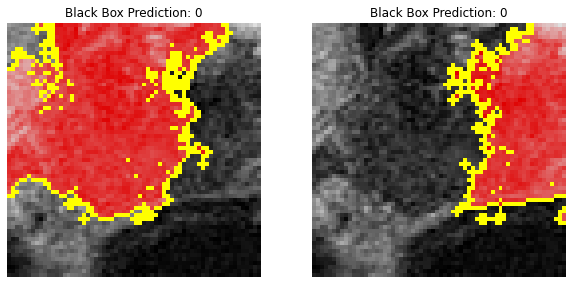

In [35]:
imgs2show, masks, coutcomes = exp.get_image_counterfactuals(hide_rest=False, 
                                                            num_features=None, 
                                                            min_importance=0.0)
if len(imgs2show)==1:
    plt.imshow(mark_boundaries(imgs2show[0], masks[0]))
    plt.title('Black Box Prediction: '+str(coutcomes[0]))
    plt.axis('off')
else:
    Fig, ax = plt.subplots(1,len(imgs2show),figsize=(5*len(imgs2show),5))
    for i in range(len(imgs2show)):
        ax[i].imshow(mark_boundaries(imgs2show[i], masks[i]))
        ax[i].set_title('Black Box Prediction: '+str(coutcomes[i]))
        ax[i].axis('off')

In [23]:
from externals.LOREM.ilorem import ILOREM

# Function to convert from rgb2gray since the one implemented in skimage gives problems
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

#The predict function needs to take as input a list of RGB image 
#and return an array of class indices of shape (-1,1)

# Create the explainer

def batch_predict_LORE(images):
    transform = transforms.ToTensor() #this already normalize RBG in range 0-1
    batch = torch.stack(tuple(transform(i) for i in images), dim=0).float()
    output = model(batch)  # Forward pass
    output = torch.nn.functional.softmax(output, dim=1)
    pred = torch.argmax(output,1)
    
    return pred.numpy().reshape(-1,1)

explainer = ILOREM(bb_predict = batch_predict_LORE, 
                   neigh_type='lime',
                   class_name='class', 
                   class_values = [0,1], 
                   segmentation_fn=segmentation_fn,
                   verbose=True)

exp = explainer.explain_instance(np.array(img)/255, 
                                 num_samples=500, 
                                 use_weights=True, #pesa i punti in base alla distanza
                                 metric='cosine',
                                 hide_color=255)

generating neighborhood - lime
synthetic neighborhood class counts {0: 301, 1: 249}
learning local decision tree
retrieving explanation


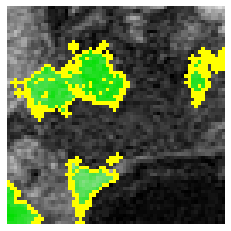

In [24]:
img2show, mask = exp.get_image_rule(hide_rest=False, 
                                    num_features=None, 
                                    min_importance=0.0)
plt.imshow(mark_boundaries(img2show,mask))
plt.axis('off');

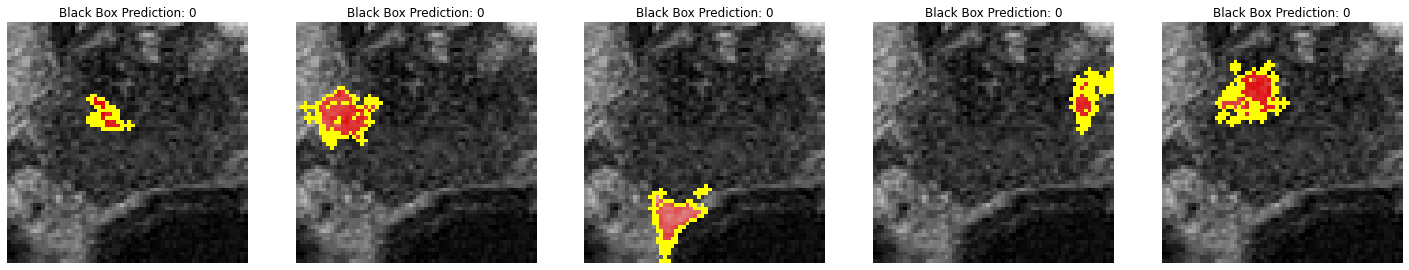

In [25]:
imgs2show, masks, coutcomes = exp.get_image_counterfactuals(hide_rest=False, 
                                                            num_features=None, 
                                                            min_importance=0.0)
if len(imgs2show)==1:
    plt.imshow(mark_boundaries(imgs2show[0], masks[0]))
    plt.title('Black Box Prediction: '+str(coutcomes[0]))
    plt.axis('off')
else:
    Fig, ax = plt.subplots(1,len(imgs2show),figsize=(5*len(imgs2show),5))
    for i in range(len(imgs2show)):
        ax[i].imshow(mark_boundaries(imgs2show[i], masks[i]))
        ax[i].set_title('Black Box Prediction: '+str(coutcomes[i]))
        ax[i].axis('off')

# ABELE

Abele uses an autoencoder in its explanation procedure, there are two way you can build one: 
* Using ABELE method
* Building you own

### Using ABELE `get_autoencoder` method: 

`get_autoencoder` creates the autoencoder class to train

* X: dataset to use to train the ae 
* ae_name: type of the autoencoder to train, only adversarial autoencoder (aae) and variational autoencoder (vae) are supported
* path_aemodels: path where to save the weights
* dataset: name of the dataset to use

OPTIONAL:

* latent_dim: latent space dimension (only use if dataset is custom)
* hidden_dim: hidden dimension of the autoencoders layers (ex: 1024 will create two layers of 1024 hidden units) (only use if dataset is custom)
* num_filters: number of filter to use in the convolutional layers (only use if dataset is custom)

### Building a customized autoencoder: 

If you want to use your own, you need to implement an autoencoder class with these funtioncs inside:
- self.encode: take the image as input and return the latent space vector
- self.decode: take a vector as input and return the reconstructed image
- self.latent_dim: int representing the number of dimensions of the latent space
- self.discriminator: (only for adversarial autoencoders) take a vector as input and output a class label

### Example with ABELE `get_autoencoder` method

In [ ]:
from externals.ABELE.experiments.exputil import get_autoencoder

Setting paths and type of autoencoder

In [ ]:
# The type of autoencoder to train ['aae','vae']
ae_name = 'aae'
# This script will save the models weights in the folder ./path/models/abele/dataset/ae_name
path = './'
dataset = 'prostate_cancer'
path_aemodels = path + 'models/abele/%s/%s/' % (dataset,ae_name)
if not os.path.exists(path_aemodels):
    os.makedirs(path_aemodels)

Setting hyperparameters

In [ ]:
# HYPER-PARAMETERS
#define the epochs and the batch size for which the autoencoder will be trained
epochs = 2000
batch_size = 64
#Print training summary every sample_interval step
sample_interval = 50

fit the autoecoder

In [ ]:
#  Get_autoencoder create the autoencoder class to train
X_test = ... #PROSTATEx-2 CHALLENGE
ae = get_autoencoder(X_test, ae_name, path_aemodels, dataset)

ae.fit(X_test, epochs=epochs, batch_size=batch_size, sample_interval=sample_interval)
# save the weights in the oath specified before
ae.save_model()
# save also some sample images to test if the autoencoderis trained correctly
ae.sample_images(epochs)

#### ABELE

In [ ]:
from externals.ABELE.ilore.ilorem import ILOREM
from externals.ABELE.ilore.util import neuclidean

In [ ]:
# load the previously trained auto encoder
ae = get_autoencoder(X_test, ae_name, path_aemodels, dataset)
ae.load_model()

In [ ]:
# create the explainer
explainer = ILOREM(batch_predict, 
                   class_name, 
                   class_values, 
                   neigh_type='hrg',
                   ocr=0.1,
                   kernel_width=None, 
                   kernel=None, 
                   autoencoder=ae, 
                   use_rgb=use_rgb, 
                   filter_crules=True, 
                   random_state=random_state, 
                   verbose=True, 
                   valid_thr=0.5,
                   alpha1=0.5, 
                   alpha2=0.5,
                   metric=neuclidean, 
                   ngen=10, 
                   mutpb=0.2, 
                   cxpb=0.5, 
                   tournsize=3, 
                   halloffame_ratio=0.1)


In [ ]:
exp = explainer.explain_instance(img, 
                                 num_samples=1000, 
                                 use_weights=True, 
                                 metric=neuclidean)